# FX Volatility Parameterization

This notebook demonstrates how to access and use the functionalities of **FX Volatility Surfaces** within the **LSEG Financial Analytics SDK**. 

**You will be able to:**
- Build volatility surface with advanced set of parameters
- Calculate multiple volatility surfaces in a single request
- Compare different volatility models

## Imports

Import the following necessary modules:
- `lseg_analytics.pricing.market_data.fx_volatility` - for FX volatility surfaces construction

This notebook uses external libraries **pandas, IPython, matplotlib**; please ensure they are installed in your Python environment (e.g. 'pip install pandas') before running the code.

In [1]:
from lseg_analytics.pricing.market_data import fx_volatility as fxv

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import copy
from IPython.display import display

## Data Preparation

Volatility surface preparation follows a structured 3-step process:
- `lseg_analytics.pricing.market_data.fx_volatility` - for FX volatility surfaces definition

**Process Overview:**
1. **Surface Definition** - Specify the underlying instrument (fx pair)
2. **Surface Parameters** - Configure volatility model and calculation settings
3. **Request Creation** - Combine definition and parameters into a request object  

Each step builds upon the previous, creating a complete request specification for the volatility surface engine.

### FX Surface svi Parameters

In [2]:
print("Step 1: Creating Surface Definition...")

currencyPair = "EURUSD"

# Create surface definition object
surface_definition = fxv.FxVolatilitySurfaceDefinition(
        instrument_code = currencyPair
        )
print(f"   ✓ Instrument: {surface_definition.instrument_code}")

print("Step 2: Configuring Surface Parameters...")
surface_parameters = fxv.FxVolatilityPricingParameters(
        calculation_date = dt.datetime.strptime("2025-01-18", "%Y-%m-%d"),
        volatility_model = fxv.CurvesAndSurfacesVolatilityModelEnum.SVI,  # Options: SVI, SABR, TWIN_LOGNORMAL
        x_axis = fxv.XAxisEnum.DELTA,                                     # Options: DATE, DELTA, MONEYNESS, STRIKE, TENOR
        y_axis = fxv.YAxisEnum.TENOR                                      # Options: same as X-axis
    )
print(f"   ✓ Surface Parameters: {surface_parameters}")


print("Step 3: Create request item...")
# Create the main request object  with basic configuration
request_item = fxv.FxVolatilitySurfaceRequestItem(
        surface_tag = f"{currencyPair}_svi_Volsurface",
        underlying_definition = surface_definition,
        surface_parameters = surface_parameters,
        underlying_type = fxv.CurvesAndSurfacesUnderlyingTypeEnum.FX,
        surface_layout = fxv.SurfaceOutput(
            format = fxv.FormatEnum.MATRIX,  # Options: LIST, MATRIX
        )
    )
print(f"   ✓ Request Item: {request_item}")

Step 1: Creating Surface Definition...
   ✓ Instrument: EURUSD
Step 2: Configuring Surface Parameters...
   ✓ Surface Parameters: {'calculationDate': '2025-01-18T00:00:00Z', 'volatilityModel': 'SVI', 'xAxis': 'Delta', 'yAxis': 'Tenor'}
Step 3: Create request item...
   ✓ Request Item: {'surfaceTag': 'EURUSD_svi_Volsurface', 'underlyingDefinition': {'instrumentCode': 'EURUSD'}, 'surfaceParameters': {'calculationDate': '2025-01-18T00:00:00Z', 'volatilityModel': 'SVI', 'xAxis': 'Delta', 'yAxis': 'Tenor'}, 'underlyingType': 'Fx', 'surfaceLayout': {'format': 'Matrix'}}


### FX Surface SABR Parameters


In [3]:
# Changing the model and keeping the same other parameters
surface_parameters_sabr = copy.deepcopy(surface_parameters)
surface_parameters_sabr.fx_swap_calculation_method = fxv.CurvesAndSurfacesFxSwapCalculationMethodEnum.FX_SWAP_IMPLIED_FROM_DEPOSIT
surface_parameters_sabr.fx_spot_object = fxv.BidAskMid(ask=2, bid=2, mid=2)
surface_parameters_sabr.interpolation_weight = fxv.InterpolationWeight(holidays=0, week_days=1, week_ends=0)
surface_parameters_sabr.price_side = fxv.CurvesAndSurfacesPriceSideEnum.BID
# surface_parameters_sabr.domestic_deposit_rate_percent_object = BidAskMid(ask=2, bid=2, mid=2)

# We can introduce quotes for FX strategies
surface_parameters_sabr.atm_volatility_object = fxv.BidAskMid(ask=10, bid=10, mid=10)
surface_parameters_sabr.butterfly10_dobject = fxv.BidAskMid(ask=10, bid=10, mid=10)
surface_parameters_sabr.butterfly25_dobject = fxv.BidAskMid(ask=10, bid=10, mid=10)
surface_parameters_sabr.risk_reversal10_dobject = fxv.BidAskMid(ask=10, bid=10, mid=10)
surface_parameters_sabr.risk_reversal25_dobject = fxv.BidAskMid(ask=10, bid=10, mid=10)


# Create another request Item for SABR
request_item_sabr = copy.deepcopy(request_item)
request_item_sabr.surface_tag = f"{currencyPair}_sabr_Volsurface"
request_item_sabr.surface_parameters = surface_parameters_sabr
print(f"   ✓ Request Item: {request_item_sabr}")

   ✓ Request Item: {'surfaceTag': 'EURUSD_sabr_Volsurface', 'underlyingDefinition': {'instrumentCode': 'EURUSD'}, 'surfaceParameters': {'calculationDate': '2025-01-18T00:00:00Z', 'volatilityModel': 'SVI', 'xAxis': 'Delta', 'yAxis': 'Tenor', 'fxSwapCalculationMethod': 'FxSwapImpliedFromDeposit', 'fxSpotObject': {'ask': 2, 'bid': 2, 'mid': 2}, 'interpolationWeight': {'holidays': 0, 'weekDays': 1, 'weekEnds': 0}, 'priceSide': 'Bid', 'atmVolatilityObject': {'ask': 10, 'bid': 10, 'mid': 10}, 'butterfly10Dobject': {'ask': 10, 'bid': 10, 'mid': 10}, 'butterfly25Dobject': {'ask': 10, 'bid': 10, 'mid': 10}, 'riskReversal10Dobject': {'ask': 10, 'bid': 10, 'mid': 10}, 'riskReversal25Dobject': {'ask': 10, 'bid': 10, 'mid': 10}}, 'underlyingType': 'Fx', 'surfaceLayout': {'format': 'Matrix'}}


In [4]:
# Execute the calculation using the calculate function
# The 'universe' parameter accepts a list of request items for batch processing
try:
    response = fxv.calculate(universe=[request_item, request_item_sabr])

    # Display response structure information
    surface_data = response['data'][0]
    if 'surface' in surface_data:
        print(f"   Calculation successful!")
        print(f"   Surface data points available: {len(surface_data['surface'])}")
    else:
        print("   No surface data found in response")
    
except Exception as e:
    print(f"   Calculation failed: {str(e)}")
    raise

   Calculation successful!
   Surface data points available: 18


## Results Display

In [5]:
# Display the raw surface data
print(response['data'][0]['surfaceTag'])
print(response['data'][1]['surfaceTag'])

EURUSD_svi_Volsurface
EURUSD_sabr_Volsurface


In [6]:
# Create DataFrame for SVI surface
vol_surface_svi = response['data'][0]['surface']
expiries = vol_surface_svi[0][1:]
deltas = []
values = []
for row in vol_surface_svi[1:]:
    deltas.append(row[0])
    values.append(row[1:])

surface_df_svi = pd.DataFrame(values, index=deltas, columns=expiries).T.astype(float)

# Create DataFrame for SABR surface
vol_surface_sabr = response['data'][1]['surface']
values = []
for row in vol_surface_sabr[1:]:
    values.append(row[1:])

surface_df_sabr = pd.DataFrame(values, index=deltas, columns=expiries).T.astype(float)

# DataFrame of Differences
differences_df = surface_df_svi - surface_df_sabr
display(differences_df.round(5))

,-0.1,-0.15,-0.2,-0.25,-0.3,-0.35,-0.4,-0.45,ATM,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1
ON,1.22500,1.22500,1.22500,1.22500,1.22500,1.22500,1.22500,1.22500,1.2250,1.22500,1.22500,1.22500,1.22500,1.22500,1.22500,1.22500,1.22500
SW,0.50000,0.47003,0.44379,0.42500,0.41621,0.41524,0.41871,0.42326,0.4255,0.42326,0.41871,0.41524,0.41621,0.42500,0.44379,0.47003,0.50000
2W,0.42500,0.35513,0.29391,0.25000,0.22930,0.22675,0.23456,0.24491,0.2500,0.24491,0.23456,0.22675,0.22930,0.25000,0.29391,0.35513,0.42500
1M,0.19950,0.14955,0.10582,0.07450,0.05984,0.05818,0.06391,0.07139,0.0750,0.07139,0.06391,0.05818,0.05984,0.07450,0.10582,0.14955,0.19950
2M,0.20000,0.16028,0.12548,0.10050,0.08870,0.08719,0.09153,0.09728,0.1000,0.09728,0.09153,0.08719,0.08870,0.10050,0.12548,0.16028,0.20000
3M,0.19950,0.14975,0.10619,0.07500,0.06041,0.05875,0.06438,0.07167,0.0750,0.07167,0.06438,0.05875,0.06041,0.07500,0.10619,0.14975,0.19950
6M,0.20000,0.15997,0.12496,0.10000,0.08849,0.08742,0.09215,0.09803,0.1005,0.09803,0.09215,0.08742,0.08849,0.10000,0.12496,0.15997,0.20000
9M,0.20000,0.14998,0.10623,0.07500,0.06055,0.05909,0.06478,0.07181,0.0745,0.07181,0.06478,0.05909,0.06055,0.07500,0.10623,0.14998,0.20000
1Y,0.17500,0.13492,0.09991,0.07500,0.06363,0.06268,0.06740,0.07303,0.0750,0.07303,0.06740,0.06268,0.06363,0.07500,0.09991,0.13492,0.17500
2Y,0.10000,0.10000,0.10000,0.10000,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,0.10000,0.10000,0.10000


### Plotting Volatility Smile for "2Y" Expiry

Text(0, 0.5, 'Volatility')

<Figure size 640x480 with 0 Axes>

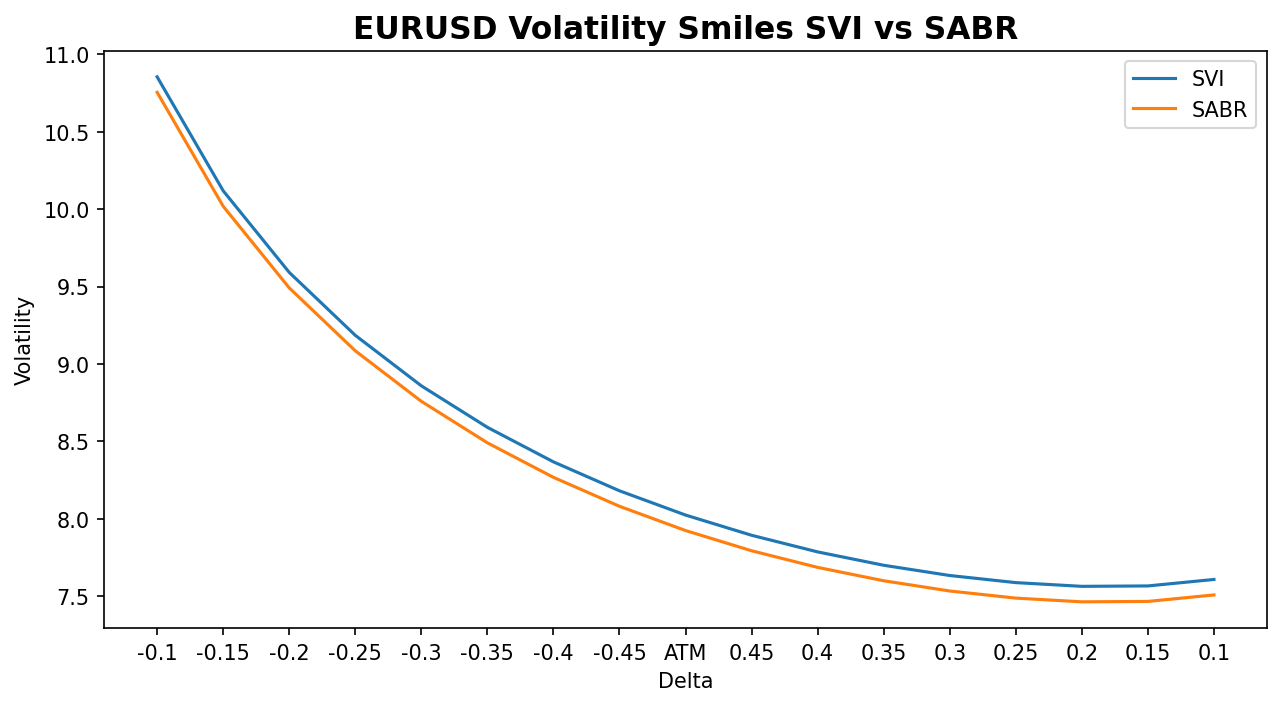

In [7]:
plt.figure()
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(surface_df_svi.columns.map(str), surface_df_svi.T["2Y"], label = "SVI")
plt.plot(surface_df_sabr.columns.map(str), surface_df_sabr.T["2Y"], label = "SABR")
plt.title(f"{currencyPair} Volatility Smiles SVI vs SABR", fontdict={'fontweight':'bold','fontsize':15})
plt.legend(loc='upper right')
plt.xlabel('Delta')
plt.ylabel('Volatility')